In [1]:
# Importações
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    roc_auc_score
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Cross validation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Similaridade de Cossenos
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re

# Caso o NLTK não esteja configurado:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/alice.ferreira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/alice.ferreira/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alice.ferreira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Define funções essenciais

# Variáveis para padronização das métricas
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "roc_auc": roc_auc_score
}

def evaluate_metrics(y_true, y_pred, y_pred_proba, metrics=metrics):
    # Calculate scores
    scores = {}
    for name, metric in metrics.items():
        # Handle metrics that require probabilities (like ROC AUC)
        if name == 'roc_auc':
            scores[name] = metric(y_true, y_pred_proba)
        else:
            scores[name] = metric(y_true, y_pred)
    return scores

In [3]:
# Importa Dataframe contendo títulos de notícias relacionadas a saúde
df = pd.read_csv('dados/df_final.zip')

# Re-transforma as listas em listas
df['title'] = df['title'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['corpo_texto'] = df['corpo_texto'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

display(df)

,title,link,date,corpo_texto,noticia_falsa
0,"[verdade, casos, mortes, covid19, diminuíram, ...",http://www.e-farsas.com/e-verdade-que-os-casos...,Data não disponível,"[verdade, casos, mortes, covid19, diminuíram, ...",0.0
1,"[estudo, recomenda, uso, máscara, contra, covi...",https://projetocomprova.com.br/publicações/est...,2020/11/06,"[postagem, facebook, fonte, estudar, verdade, ...",0.0
2,"[covid, vai, parar, infectar, maioria, pessoas...",https://www.boatos.org/saude/covid-parar-quand...,26/11/2020,"[explicar, milésimo, vir, enfiar, cabeça, pess...",0.0
3,"[considerações, críticas, vacinas, contra, cov...",https://medicospelavidacovid19.com.br/geral/co...,Data não disponível,"[considerações, críticas, vacinas, contra, cov...",0.0
4,"[janssen, fará, reunião, dia, 16, pedir, uso, ...",https://noticias.uol.com.br/ultimas-noticias/r...,04/03/2021 22h21,"[janssen, subsidiário, johnson, johnson, pedir...",1.0
...,...,...,...,...,...
3330,"[cidade, lourenço, zerou, internação, covid, g...",https://www.e-farsas.com/a-cidade-de-sao-loure...,16/03/2021,"[publicação, espalhar, rede, social, whatsapp,...",0.0
3331,"[esquemas, vacinaisacesse, esquemas, vacinais,...",https://www.gov.br/saude/pt-br/assuntos/covid-...,Data não disponível,"[esquemas, vacinais, ministério, saúde, ir, co...",1.0
3332,"[saúde, autoriza, 45, leitos, uti, covid19, se...",https://www.gov.br/saude/pt-br/assuntos/notici...,14/04/2021 17h57,"[ministério, saudar, autorizar, n, quartafeira...",1.0
3333,"[fake, foto, mostre, coração, pessoa, após, us...",https://g1.globo.com/fato-ou-fake/coronavirus/...,01/09/2020,"[circular, rede, social, foto, coração, predom...",0.0


In [4]:
# Separa porção para validação
df_main, df_validation = train_test_split(df, test_size=0.25, random_state=42, stratify=df['noticia_falsa'])

display(df_main, df_validation)

,title,link,date,corpo_texto,noticia_falsa
2548,"[artigo, prova, impossibilidade, transmissão, ...",https://projetocomprova.com.br/publicações/art...,2020/11/30,"[autor, artigo, ouvir, permitir, comprovar, in...",0.0
2330,"[dinho, ouro, preto, pega, coronavírus, web, p...",https://entretenimento.uol.com.br/noticias/red...,26/03/2020 14h56,"[vocalista, capital, inicial, dinho, ourar, pr...",1.0
1502,"[estudo, padrão, ouro, universidade, oxford, c...",https://medicospelavidacovid19.com.br/noticias...,Data não disponível,"[estudo, padrão, ouro, universidade, oxford, c...",0.0
1555,"[casos, coronavírus, china, podem, fagulha, in...",https://noticias.uol.com.br/saude/ultimas-noti...,10/02/2020 20h29,"[organização, mundial, saudar, oms, afirmar, h...",1.0
2033,"[covid, avião, 7º, lote, chega, viracopos, bra...",https://g1.globo.com/sp/campinas-regiao/notici...,02/06/2021 19h07,"[lotar, vacinar, covid19, pfizer, biontech, ch...",1.0
...,...,...,...,...,...
2297,"[convivemos, pandemia, podemos, ficar, anestes...",https://noticias.uol.com.br/ultimas-noticias/a...,08/08/2020 16h09,"[presidente, câmara, deputar, rodrigar, maio, ...",1.0
1431,"[calendário, técnico, nacional, vacinação, ges...",https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,"[calendário, técnico, nacional, vacinação, ges...",1.0
3300,"[monitoramento, encontra, dobro, mortes, índig...",https://extra.globo.com/noticias/coronavirus/m...,Publicado em 12/04/21 17:59,"[rir, morte, indígena, fevereiro, outubro, div...",1.0
1263,"[fernando, parrillo, dono, prevent, sênior, di...",https://www.boatos.org/saude/fernando-parrillo...,19/03/2020,"[oi, fabiano, brigar, brigar, palavra, realmen...",0.0


,title,link,date,corpo_texto,noticia_falsa
3286,"[alguns, povos, antigos, sacrificavam, maus, p...",http://www.e-farsas.com/alguns-povos-antigos-s...,Data não disponível,"[alguns, povos, antigos, sacrificavam, maus, p...",0.0
2897,"[pandemia, fraude, crime, contra, humanidade, ...",https://noticias.uol.com.br/comprova/ultimas-n...,27/10/2020 20h25,"[vídeo, canal, youtube, apresentador, pandemia...",0.0
2968,"[coronavírus, 1ª, vez, brasil, 200, mortes, co...",https://noticias.uol.com.br/saude/ultimas-noti...,14/04/2020 16h54Atualizada em 14/04/2020 20h43,"[ministério, saudar, anunciar, hoje, subir, 15...",1.0
3039,"[após, avanços, reabertura, santiago, registra...",https://noticias.uol.com.br/ultimas-noticias/e...,22/08/2020 23h39,"[chile, somar, n, sábado, 1926, caso, covid19,...",1.0
482,"[testes, positivos, covid19, sp, atingem, índi...",https://noticias.uol.com.br/saude/ultimas-noti...,03/12/2020 04h00,"[cercar, semana, laboratório, farmácia, cresci...",1.0
...,...,...,...,...,...
3050,"[saúde, repassa, r, 143, milhões, centros, enf...",https://www.gov.br/saude/pt-br/assuntos/notici...,Data não disponível,"[saúde, repassa, r, 143, milhões, centros, enf...",1.0
2111,"[pb, união, estado, devem, regularizar, insumo...",https://noticias.uol.com.br/saude/ultimas-noti...,25/06/2020 14h10,"[justiçar, federal, atender, pedir, liminar, f...",1.0
3264,"[vídeo, rui, costa, jaques, wagner, otto, alen...",https://checamos.afp.com//video-de-rui-costa-j...,18/06/2021 às 18:12,"[turma, ficar, casar, cpi, cloroquina, mascara...",0.0
2951,"[foto, mostrar, pessoa, máscara, piscina, pari...",https://www.e-farsas.com/foto-mostra-pessoas-u...,7/06/20207,"[publicação, compartilhar, receber, 23, reações]",0.0


In [5]:
# Checa distribuição de classes entre dados separados
print(f'Distribuição para o df principal: {df_main['noticia_falsa'].value_counts()[0]/\
      df_main['noticia_falsa'].value_counts()[1]}')
print(f'\nDistribuição para o df de validação: {df_validation['noticia_falsa'].value_counts()[0]/\
      df_validation['noticia_falsa'].value_counts()[1]}')

Distribuição para o df principal: 0.4781323877068558

Distribuição para o df de validação: 0.4787234042553192


In [6]:
# Inicializa o vetorizador de TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Criação de vetores
X = df_main['title'].apply(lambda x: ' '.join(x))
y = df_main['noticia_falsa']

print("Dimensões de X:", X.shape)
print("Dimensões de y:", y.shape)

Dimensões de X: (2501,)
Dimensões de y: (2501,)


### Árvore de Decisão

In [7]:
# Cria modelo e define pipeline com TF-IDF
modelo_ad = DecisionTreeClassifier()
pipeline_ad = Pipeline([('TF-IDF', tfidf_vectorizer), ('modelo', modelo_ad)])

# Validação cruzada
resultados_ad = cross_validate(pipeline_ad, X, y, scoring=[score for score in metrics.keys()])

acc_ad = resultados_ad['test_accuracy'].mean()
acc_ad_std = np.std(resultados_ad['test_accuracy'])
prec_ad = resultados_ad['test_precision'].mean()
prec_ad_std = np.std(resultados_ad['test_precision'])
rocauc_ad = resultados_ad['test_roc_auc'].mean()
rocauc_ad_std = np.std(resultados_ad['test_roc_auc'])
print(f'Acurácia: {acc_ad:.3f}\nPrecisão: {prec_ad:.3f}\nROC-AUC: {rocauc_ad:.3f}')

Acurácia: 0.821
Precisão: 0.871
ROC-AUC: 0.801


### Floresta Aleatória

In [8]:
# Cria modelo
modelo_rf = RandomForestClassifier()
pipeline_rf = Pipeline([('TF-IDF', tfidf_vectorizer), ('modelo', modelo_rf)])

# Validação cruzada
resultados_rf = cross_validate(pipeline_rf, X, y, scoring=[score for score in metrics.keys()])

acc_rf = resultados_rf['test_accuracy'].mean()
acc_rf_std = np.std(resultados_rf['test_accuracy'])
prec_rf = resultados_rf['test_precision'].mean()
prec_rf_std = np.std(resultados_rf['test_precision'])
rocauc_rf = resultados_rf['test_roc_auc'].mean()
rocauc_rf_std = np.std(resultados_rf['test_roc_auc'])
print(f'Acurácia: {acc_rf:.3f}\nPrecisão: {prec_rf:.3f}\nROC-AUC: {rocauc_rf:.3f}')

Acurácia: 0.870
Precisão: 0.865
ROC-AUC: 0.917


### Regressão Logística

In [9]:
# Cria modelo
modelo_lr = LogisticRegression()
pipeline_lr = Pipeline([('TF-IDF', tfidf_vectorizer), ('modelo', modelo_lr)])

# Validação cruzada
resultados_lr = cross_validate(pipeline_lr, X, y, scoring=[score for score in metrics.keys()])

acc_lr = resultados_lr['test_accuracy'].mean()
acc_lr_std = np.std(resultados_lr['test_accuracy'])
prec_lr = resultados_lr['test_precision'].mean()
prec_lr_std = np.std(resultados_lr['test_precision'])
rocauc_lr = resultados_lr['test_roc_auc'].mean()
rocauc_lr_std = np.std(resultados_lr['test_roc_auc'])
print(f'Acurácia: {acc_lr:.3f}\nPrecisão: {prec_lr:.3f}\nROC-AUC: {rocauc_lr:.3f}')

Acurácia: 0.863
Precisão: 0.840
ROC-AUC: 0.939


### SVM

In [10]:
# Parâmetros
C = 77
kernel = 'rbf'
gamma = 0.01

# Cria modelo
modelo_svm = svm.SVC(C=C, kernel=kernel, gamma=gamma, probability=True)
pipeline_svm = Pipeline([('TF-IDF', tfidf_vectorizer), ('modelo', modelo_svm)])

# Validação cruzada
resultados_svm = cross_validate(pipeline_svm, X, y, scoring=[score for score in metrics.keys()])

acc_svm = resultados_svm['test_accuracy'].mean()
acc_svm_std = np.std(resultados_svm['test_accuracy'])
prec_svm = resultados_svm['test_precision'].mean()
prec_svm_std = np.std(resultados_svm['test_precision'])
rocauc_svm = resultados_svm['test_roc_auc'].mean()
rocauc_svm_std = np.std(resultados_svm['test_roc_auc'])
print(f'Acurácia: {acc_svm:.3f}\nPrecisão: {prec_svm:.3f}\nROC-AUC: {rocauc_svm:.3f}')

Acurácia: 0.895
Precisão: 0.898
ROC-AUC: 0.944


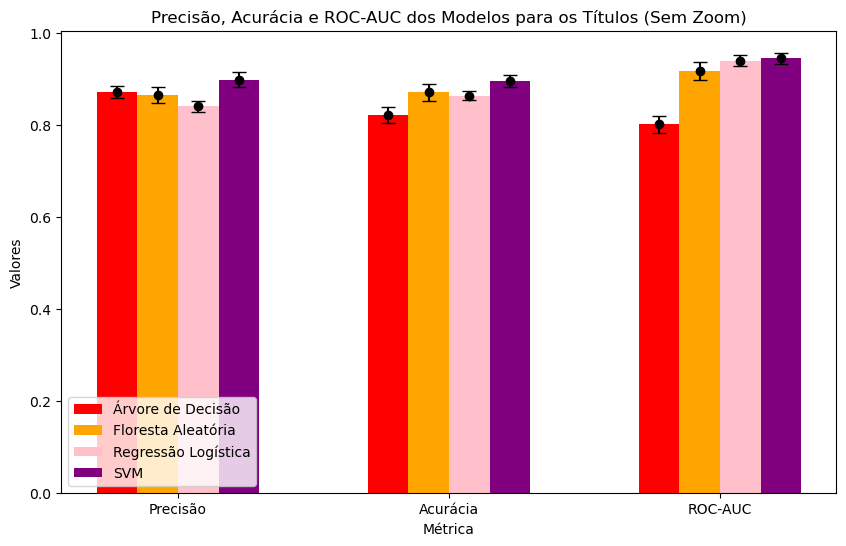

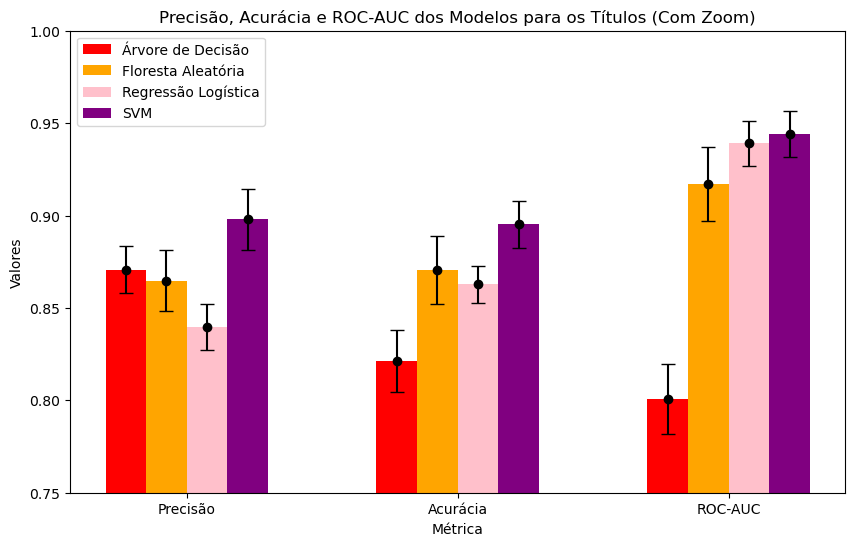

In [11]:
# Definindo os dados
accuracy_list = [acc_ad, acc_rf, acc_lr, acc_svm]
precision_list = [prec_ad, prec_rf, prec_lr, prec_svm]
rocauc_list = [rocauc_ad, rocauc_rf, rocauc_lr, rocauc_svm]
acc_std_list = [acc_ad_std, acc_rf_std, acc_lr_std, acc_svm_std]
prec_std_list = [prec_ad_std, prec_rf_std, prec_lr_std, prec_svm_std]
rocauc_std_list = [rocauc_ad_std, rocauc_rf_std, rocauc_lr_std, rocauc_svm_std]
model_labels = ['Árvore de Decisão', 'Floresta Aleatória', 'Regressão Logística', 'SVM']
colors = ['red', 'orange', 'pink', 'purple']

# Posições das barras para os grupos
x = np.arange(3)  # Precisão, Acurácia e ROC-AUC
width = 0.15      # Largura das barras

# Criando o gráfico sem zoom
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(model_labels)):
    # Precisão
    ax.bar(x[0] + i * width - (1.5 * width), precision_list[i], width, label=model_labels[i], color=colors[i])
    ax.errorbar(x[0] + i * width - (1.5 * width), precision_list[i], yerr=prec_std_list[i], fmt='o', color='black', capsize=5)
    # Acurácia
    ax.bar(x[1] + i * width - (1.5 * width), accuracy_list[i], width, color=colors[i])
    ax.errorbar(x[1] + i * width - (1.5 * width), accuracy_list[i], yerr=acc_std_list[i], fmt='o', color='black', capsize=5)
    # ROC-AUC
    ax.bar(x[2] + i * width - (1.5 * width), rocauc_list[i], width, color=colors[i])
    ax.errorbar(x[2] + i * width - (1.5 * width), rocauc_list[i], yerr=rocauc_std_list[i], fmt='o', color='black', capsize=5)

# Configurando os rótulos e título
ax.set_xlabel('Métrica')
ax.set_ylabel('Valores')
ax.set_title('Precisão, Acurácia e ROC-AUC dos Modelos para os Títulos (Sem Zoom)')
ax.set_xticks(x)
ax.set_xticklabels(['Precisão', 'Acurácia', 'ROC-AUC'])
ax.legend()

# Exibindo o gráfico sem zoom
plt.show()

# Criando o gráfico com zoom
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(model_labels)):
    # Precisão
    ax.bar(x[0] + i * width - (1.5 * width), precision_list[i], width, label=model_labels[i], color=colors[i])
    ax.errorbar(x[0] + i * width - (1.5 * width), precision_list[i], yerr=prec_std_list[i], fmt='o', color='black', capsize=5)
    # Acurácia
    ax.bar(x[1] + i * width - (1.5 * width), accuracy_list[i], width, color=colors[i])
    ax.errorbar(x[1] + i * width - (1.5 * width), accuracy_list[i], yerr=acc_std_list[i], fmt='o', color='black', capsize=5)
    # ROC-AUC
    ax.bar(x[2] + i * width - (1.5 * width), rocauc_list[i], width, color=colors[i])
    ax.errorbar(x[2] + i * width - (1.5 * width), rocauc_list[i], yerr=rocauc_std_list[i], fmt='o', color='black', capsize=5)

# Configurando os rótulos e título
ax.set_xlabel('Métrica')
ax.set_ylabel('Valores')
ax.set_title('Precisão, Acurácia e ROC-AUC dos Modelos para os Títulos (Com Zoom)')
ax.set_xticks(x)
ax.set_xticklabels(['Precisão', 'Acurácia', 'ROC-AUC'])
ax.legend()

# Definindo o limite do eixo y para dar o "zoom"
plt.ylim(0.75, 1)

# Exibindo o gráfico com zoom
plt.show()

### Teste com dados separados pra validação

In [12]:
# Inicializa o vetorizador de TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Criação de vetores
X_val = df_validation['title'].apply(lambda x: ' '.join(x))
y_val = df_validation['noticia_falsa'].to_numpy()

print("Dimensões de X:", X_val.shape)
print("Dimensões de y:", y_val.shape)

Dimensões de X: (834,)
Dimensões de y: (834,)


In [13]:
# Calcula score de cada método para df de validação

pipelines = [pipeline_ad, pipeline_rf, pipeline_lr, pipeline_svm]

accuracy_list = []
precision_list = []
rocauc_list = []


for pipeline in pipelines:
    pipeline.fit(X,y)
    y_val_pred = pipeline.predict(X_val)
    y_val_pred_proba = pipeline.predict_proba(X_val)[:,1]
    scores = evaluate_metrics(y_val, y_val_pred, y_val_pred_proba)
    
    accuracy_list.append(scores['accuracy'])
    precision_list.append(scores['precision'])
    rocauc_list.append(scores['roc_auc'])
    
    print(f'{str(pipeline[1])}:\n    Acurácia: {scores['accuracy']:.3f}\
        \n    Precisão: {scores['precision']:.3f}\n    ROC-AUC: {scores['roc_auc']:.3f}\n')

DecisionTreeClassifier():
    Acurácia: 0.844        
    Precisão: 0.896
    ROC-AUC: 0.836

RandomForestClassifier():
    Acurácia: 0.876        
    Precisão: 0.884
    ROC-AUC: 0.933

LogisticRegression():
    Acurácia: 0.886        
    Precisão: 0.865
    ROC-AUC: 0.970

SVC(C=77, gamma=0.01, probability=True):
    Acurácia: 0.924        
    Precisão: 0.930
    ROC-AUC: 0.966



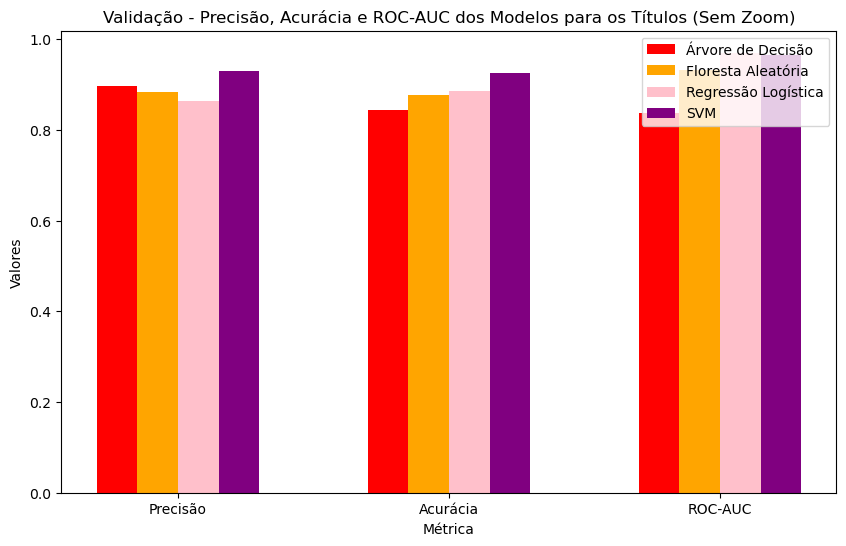

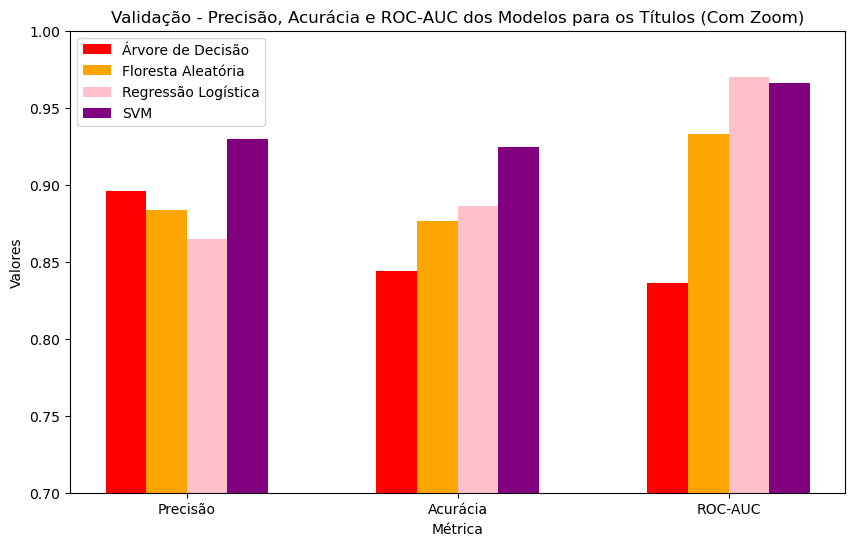

In [14]:
# Positions for the groups of bars
x = np.arange(3)  # One point for "Precision", "Accuracy", and "ROC-AUC"
width = 0.15  # Width of the bars

# Creating the plot without zoom
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(model_labels)):
    # Precision
    ax.bar(x[0] + i * width - (1.5 * width), precision_list[i], width, label=model_labels[i], color=colors[i])
    # Accuracy
    ax.bar(x[1] + i * width - (1.5 * width), accuracy_list[i], width, color=colors[i])
    # ROC-AUC
    ax.bar(x[2] + i * width - (1.5 * width), rocauc_list[i], width, color=colors[i])

# Configuring labels and title
ax.set_xlabel('Métrica')
ax.set_ylabel('Valores')
ax.set_title('Validação - Precisão, Acurácia e ROC-AUC dos Modelos para os Títulos (Sem Zoom)')
ax.set_xticks(x)
ax.set_xticklabels(['Precisão', 'Acurácia', 'ROC-AUC'])
ax.legend()

# Displaying the plot without zoom
plt.show()

# Creating the plot with zoom
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(model_labels)):
    # Precision
    ax.bar(x[0] + i * width - (1.5 * width), precision_list[i], width, label=model_labels[i], color=colors[i])
    # Accuracy
    ax.bar(x[1] + i * width - (1.5 * width), accuracy_list[i], width, color=colors[i])
    # ROC-AUC
    ax.bar(x[2] + i * width - (1.5 * width), rocauc_list[i], width, color=colors[i])

# Configuring labels and title
ax.set_xlabel('Métrica')
ax.set_ylabel('Valores')
ax.set_title('Validação - Precisão, Acurácia e ROC-AUC dos Modelos para os Títulos (Com Zoom)')
ax.set_xticks(x)
ax.set_xticklabels(['Precisão', 'Acurácia', 'ROC-AUC'])
ax.legend()

# Setting y-axis limit for zoom
plt.ylim(0.7, 1)

# Displaying the plot with zoom
plt.show()